In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

print("Analysis notebook loaded.")

Analysis notebook loaded.


In [2]:
# --- 1. IMPORTS ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import matplotlib as mpl
import seaborn as sns
import networkx as nx
import yfinance as yf
import requests
import json
import os
import time
import warnings
from pathlib import Path
from scipy.sparse.csgraph import minimum_spanning_tree
from scipy.sparse import csr_matrix
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')

# --- 2. PATH CONFIGURATION ---
# (Assuming your notebook is in the root 'QuantProject' folder)
RAW_DATA_DIR = "data/raw_nifty50"
PROCESSED_DATA_DIR = "data/processed"
OUTPUT_DIR = "data/output"

# Create all directories
os.makedirs(RAW_DATA_DIR, exist_ok=True)
os.makedirs(PROCESSED_DATA_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("All libraries imported and paths are set.")

# --- 3. DEFINE SYMBOLS ---
NIFTY50_SYMBOLS = [
  "ADANIPORTS.NS","APOLLOHOSP.NS","ASIANPAINT.NS","AXISBANK.NS","BAJAJ-AUTO.NS",
  "BAJAJFINSV.NS","BAJFINANCE.NS","BPCL.NS","BHARTIARTL.NS","BRITANNIA.NS",
  "CIPLA.NS","COALINDIA.NS","DIVISLAB.NS","DRREDDY.NS","EICHERMOT.NS",
  "GRASIM.NS","HCLTECH.NS","HDFCBANK.NS","HDFCLIFE.NS","HEROMOTOCO.NS",
  "HINDALCO.NS","HINDUNILVR.NS","ICICIBANK.NS","INDUSINDBK.NS","INFY.NS",
  "ITC.NS","JSWSTEEL.NS","KOTAKBANK.NS","LT.NS","M&M.NS",
  "MARUTI.NS","NESTLEIND.NS","NTPC.NS","ONGC.NS","POWERGRID.NS",
  "RELIANCE.NS","SBILIFE.NS","SBIN.NS","SHREECEM.NS","SUNPHARMA.NS",
  "TATACONSUM.NS","TATAMOTORS.NS","TATASTEEL.NS","TCS.NS","TECHM.NS",
  "TITAN.NS","ULTRACEMCO.NS","UPL.NS","WIPRO.NS", "SHRIRAMFIN.NS"
]
print(f"Defined {len(NIFTY50_SYMBOLS)} Nifty 50 symbols.")

# --- 4. DOWNLOAD STOCK OHLCV DATA ---
start_date = '2010-01-01'
end_date = pd.Timestamp.today().strftime('%Y-%m-%d')
all_prices = {} # This will be used in the NEXT cell (Consolidation)

print("\nDownloading stock data from yfinance...")
# Use yf.download for all tickers at once, it's more efficient
data = yf.download(NIFTY50_SYMBOLS, start=start_date, end=end_date, auto_adjust=True)

# Process and save each stock's data
for symbol in NIFTY50_SYMBOLS:
    try:
        df = data.loc[:, (slice(None), symbol)]
        df.columns = df.columns.get_level_values(0)
        df = df.dropna()
        
        if not df.empty:
            df.to_csv(os.path.join(RAW_DATA_DIR, f"{symbol}.csv"))
            all_prices[symbol] = df # Store in memory for next cell
        else:
            print(f"No data for {symbol}, skipping.")
    except Exception as e:
        print(f"Error processing {symbol}: {e}")

print(f"\nDownloaded and saved raw data for {len(all_prices)} stocks to {os.path.abspath(RAW_DATA_DIR)}")

# --- 5. DOWNLOAD SECTOR DATA ---
SECTOR_FILE = os.path.join(PROCESSED_DATA_DIR, "nifty50_sectors.json") # This line will now work

print("\nFetching sector data...")
sector_map = {}
for ticker_str in NIFTY50_SYMBOLS:
    try:
        ticker = yf.Ticker(ticker_str)
        info = ticker.info
        sector = info.get('sector', info.get('industry', 'Unknown'))
        sector_map[ticker_str] = sector
    except Exception as e:
        sector_map[ticker_str] = "Unknown"
        
with open(SECTOR_FILE, 'w') as f:
    json.dump(sector_map, f, indent=4)
print(f"Sector data saved to {os.path.abspath(SECTOR_FILE)}")

All libraries imported and paths are set.
Defined 50 Nifty 50 symbols.



[*********************100%***********************]  50 of 50 completed



Downloaded and saved raw data for 50 stocks to E:\QuantProject\data\raw_nifty50

Fetching sector data...
Sector data saved to E:\QuantProject\data\processed\nifty50_sectors.json


In [3]:
import pandas as pd
import numpy as np
import os
import time

# --- Configuration (from your notebook) ---
# Ensure these paths are correct
PROCESSED_DATA_DIR = "data/processed"
# These variables should be in memory from Cell 1:
# all_prices (dict)
# PROCESSED_DATA_DIR (str)

print("--- Starting Feature Generation (Manual) ---")

try:
    if 'all_prices' not in locals() or not all_prices:
        raise NameError("Variable 'all_prices' not found or is empty. Please re-run Cell 1 (Data Download).")

    # --- 1. Create `all_price_data.csv` ---
    # engine.py expects a multi-index file.
    # We can create this by concatenating the dict from Cell 1.
    multi_index_df = pd.concat(all_prices, axis=1)
    multi_index_df.to_csv(os.path.join(PROCESSED_DATA_DIR, 'all_price_data.csv'))
    print(f"Saved: all_price_data.csv ({multi_index_df.shape})")
    
    # --- 2. Consolidate 'Close', 'High', 'Low' for manual features ---
    # (This is what your Cell 2 did, but using the in-memory 'all_prices')
    close_prices = pd.concat({symbol: df['Close'] for symbol, df in all_prices.items()}, axis=1)
    high_prices = pd.concat({symbol: df['High'] for symbol, df in all_prices.items()}, axis=1)
    low_prices = pd.concat({symbol: df['Low'] for symbol, df in all_prices.items()}, axis=1)
    
    # --- 3. Create `all_returns_data.csv` ---
    returns = close_prices.pct_change()
    returns.to_csv(os.path.join(PROCESSED_DATA_DIR, 'all_returns_data.csv'))
    print(f"Saved: all_returns_data.csv ({returns.shape})")

    # --- 4. Manual Feature Calculations (from your Cell 2) ---
    
    # Define periods REQUIRED by engine.py
    RSI_PERIOD = 14
    ATR_PERIOD = 14
    SMA_PERIODS_REQUIRED = [20, 50] # This is the fix (your old cell had 50, 200)

    # Calculate SMAs
    for period in SMA_PERIODS_REQUIRED:
        print(f"Calculating SMA {period}...")
        sma_df = close_prices.rolling(window=period).mean()
        # Save with the name engine.py expects
        sma_df.to_csv(os.path.join(PROCESSED_DATA_DIR, f'sma_{period}_50.csv'))
        print(f"Saved: sma_{period}_50.csv")

    # Calculate RSI (using your manual logic)
    print(f"Calculating RSI {RSI_PERIOD}...")
    delta = close_prices.diff()
    gain = delta.where(delta > 0, 0.0)
    loss = -delta.where(delta < 0, 0.0)
    avg_gain = gain.ewm(com=RSI_PERIOD - 1, min_periods=RSI_PERIOD).mean()
    avg_loss = loss.ewm(com=RSI_PERIOD - 1, min_periods=RSI_PERIOD).mean()
    rs = avg_gain / avg_loss
    rsi_df = 100.0 - (100.0 / (1.0 + rs))
    rsi_df.to_csv(os.path.join(PROCESSED_DATA_DIR, f'rsi_{RSI_PERIOD}_50.csv'))
    print(f"Saved: rsi_{RSI_PERIOD}_50.csv")

    # Calculate ATR (using your manual logic)
    print(f"Calculating ATR {ATR_PERIOD}...")
    high_low = high_prices - low_prices
    high_close_prev = np.abs(high_prices - close_prices.shift(1))
    low_close_prev = np.abs(low_prices - close_prices.shift(1))
    
    temp_max = np.maximum(high_low, high_close_prev)
    true_range = np.maximum(temp_max, low_close_prev)
    
    atr_df = true_range.ewm(alpha=1/ATR_PERIOD, adjust=False, min_periods=ATR_PERIOD).mean()
    atr_df.to_csv(os.path.join(PROCESSED_DATA_DIR, f'atr_{ATR_PERIOD}_50.csv'))
    print(f"Saved: atr_{ATR_PERIOD}_50.csv")

    print("\n--- All 6 processed files created successfully! ---")

except NameError as e:
    print(f"\n--- ERROR ---")
    print(f"{e}")
    print("Please make sure you have run Cell 1 (Data Download) first.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")


--- Starting Feature Generation (Manual) ---
Saved: all_price_data.csv ((3908, 250))
Saved: all_returns_data.csv ((3908, 50))
Calculating SMA 20...
Saved: sma_20_50.csv
Calculating SMA 50...
Saved: sma_50_50.csv
Calculating RSI 14...
Saved: rsi_14_50.csv
Calculating ATR 14...
Saved: atr_14_50.csv

--- All 6 processed files created successfully! ---


In [4]:
# --- Define Paths ---
PROCESSED_DIR = 'data/processed'
TMFG_PATH = os.path.join(PROCESSED_DIR, 'TMFG_50.gml')
EMBEDDINGS_PATH = os.path.join(PROCESSED_DIR, 'gnn_embeddings_50.csv')
SECTORS_PATH = os.path.join(PROCESSED_DIR, 'nifty50_sectors.json')
PRICE_DATA_PATH = os.path.join(PROCESSED_DIR, 'close_50.csv')

# --- Load Data ---
try:
    # Load the graph
    G = nx.read_gml(TMFG_PATH)
    
    # Load the GNN embeddings
    embeddings_df = pd.read_csv(EMBEDDINGS_PATH, index_col=0)
    
    # Load the sector "ground truth"
    with open(SECTORS_PATH, 'r') as f:
        sectors_dict = json.load(f)
    sector_map = pd.Series(sectors_dict, name="Sector")
    
    # Load prices to calculate financial metrics
    price_df = pd.read_csv(PRICE_DATA_PATH, index_col='Date', parse_dates=True)
    
    print("Successfully loaded TMFG, embeddings, sectors, and price data.")
    print(f"Graph nodes: {len(G.nodes())}")
    print(f"Embeddings shape: {embeddings_df.shape}")

except FileNotFoundError as e:
    print(f"Error: Could not find a required file.")
    print(e)
    print("Please ensure your 'data/processed/' folder contains all outputs from the original main.ipynb run.")

Successfully loaded TMFG, embeddings, sectors, and price data.
Graph nodes: 50
Embeddings shape: (50, 16)


In [5]:
# This script builds the TRUE TMFG network using the downloaded 'TMFG.py' script.
# It includes the corrected call to fit_transform using keywords.

import pandas as pd
import numpy as np
import os
import networkx as nx

# --- IMPORTANT: Make sure TMFG.py is in the same folder as your notebook ---
try:
    from TMFG import TMFG
except ImportError:
    print("ERROR: Could not import TMFG. Make sure the 'TMFG.py' file is in your project's root folder.")
    raise

# --- Configuration ---
PROCESSED_DATA_DIR = "data/processed"
INPUT_FILE = os.path.join(PROCESSED_DATA_DIR, 'close_50.csv') # Using Nifty 50
OUTPUT_GRAPH_FILE = os.path.join(PROCESSED_DATA_DIR, 'TMFG_50.gml') # Using Nifty 50

# --- Main Logic ---

def build_tmf_graph(close_prices_file, output_file):
    """
    Loads consolidated closing prices, calculates a correlation matrix,
    builds the TMFG using the new library, and saves the resulting graph.
    """
    print(f"Loading data from {close_prices_file}...")
    try:
        close_df = pd.read_csv(
            close_prices_file, 
            index_col='Date', 
            parse_dates=True, 
            date_format='%Y-%m-%d'
        )
    except FileNotFoundError:
        print(f"ERROR: Could not find the file '{close_prices_file}'.")
        print("Please ensure you have run the data consolidation script first.")
        return None

    print("Calculating daily returns...")
    returns_df = close_df.pct_change().dropna()
    returns_df.replace([np.inf, -np.inf], 0, inplace=True)

    print("Calculating correlation matrix...")
    corr_matrix = returns_df.corr(method='spearman')
    
    # We use correlation (high=good) as the 'weights' for the TMFG
    weights_matrix = corr_matrix.abs()

    print("Building the Triangulated Maximally Filtered Graph (TMFG)...")
    
    # --- FIX: Instantiate with no args, pass 'output' to fit_transform ---
    # 1. Instantiate the TMFG class
    tmfg_model = TMFG()
    
    try:
        # 2. Call fit_transform, passing all arguments by keyword
        cliques, separators, tmf_adjacency_matrix = tmfg_model.fit_transform(
            weights=weights_matrix, 
            output='weighted_sparse_W_matrix',
            cov=corr_matrix
        )
    except Exception as e:
        print(f"ERROR: TMFG fit_transform failed. Error: {e}")
        return None
    # --- END FIX ---

    # Convert the resulting sparse matrix to a NetworkX graph
    tmf_graph = nx.from_numpy_array(tmf_adjacency_matrix)
    
    # Map the integer node labels back to the stock ticker names
    mapping = {i: ticker for i, ticker in enumerate(corr_matrix.columns)}
    nx.relabel_nodes(tmf_graph, mapping, copy=False)
    
    # Add correlation weights to the edges
    for u, v in tmf_graph.edges():
        tmf_graph[u][v]['correlation'] = corr_matrix.loc[u, v]

    print(f"Saving the TMFG graph to {output_file}...")
    nx.write_gml(tmf_graph, output_file)

    print("\nSuccessfully built and saved the TMFG network.")
    return tmf_graph

# --- Main Execution ---
tmf_network = build_tmf_graph(INPUT_FILE, OUTPUT_GRAPH_FILE)
if tmf_network:
    print(f"\nGraph Info:")
    print(f"Number of nodes: {tmf_network.number_of_nodes()}")
    print(f"Number of edges: {tmf_network.number_of_edges()}")

Loading data from data/processed\close_50.csv...
Calculating daily returns...
Calculating correlation matrix...
Building the Triangulated Maximally Filtered Graph (TMFG)...
Saving the TMFG graph to data/processed\TMFG_50.gml...

Successfully built and saved the TMFG network.

Graph Info:
Number of nodes: 50
Number of edges: 144


Created color map for 10 sectors.
Visualizing TMFG... looking for industry clusters.


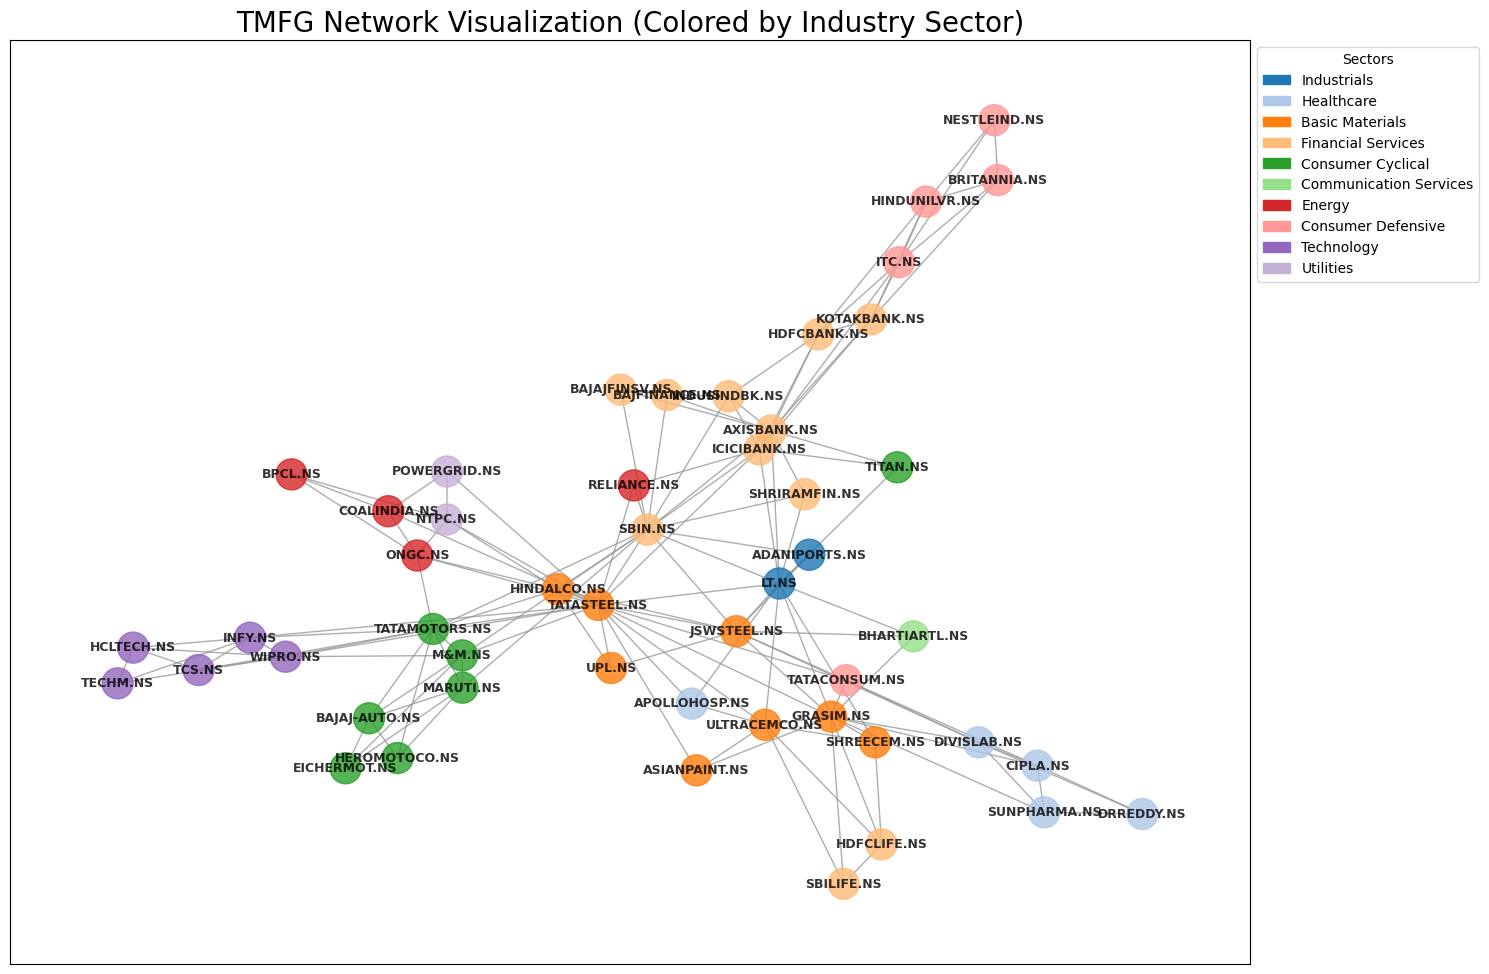

In [9]:
# --- TMFG Validation (Financial Sanity Check) ---
# We will visualize the graph and color the nodes by their industry sector.
# A good TMFG should show clear clusters of related companies.

try:
    # --- THIS IS THE FIX (Part 1) ---
    # We get the unique sectors directly from the 'analysis_df'
    # which we already know exists from the t-SNE plot.
    unique_sectors = analysis_df['Sector'].unique()
    
    # Create a color palette from seaborn
    palette = sns.color_palette("tab20", n_colors=len(unique_sectors))
    
    # Create the color dictionary (e.g., "Financials": "blue")
    sector_colors = dict(zip(unique_sectors, palette))
    
    print(f"Created color map for {len(unique_sectors)} sectors.")

except NameError as e:
    print(f"ERROR: '{e}' - 'analysis_df' not found.")
    print("Please re-run your data-loading and t-SNE cells before running this one.")
    
# --- THIS IS THE FIX (Part 2) ---
# Create a reliable lookup dictionary from the analysis_df
# This maps 'ACC.NS' -> 'Materials'
try:
    sector_lookup = analysis_df['Sector'].to_dict()
except NameError:
    sector_lookup = {} # Will fail gracefully below

# Now, we can run your plotting code
if 'G' in locals() and 'sector_lookup':
    print("Visualizing TMFG... looking for industry clusters.")
    
    # Get node colors using our new, reliable 'sector_lookup'
    node_colors = [sector_colors.get(sector_lookup.get(node, 'Unknown'), '#808080') for node in G.nodes()]

    plt.figure(figsize=(16, 12))
    pos = nx.spring_layout(G, k=0.1, iterations=50, seed=42) 
    
    nx.draw_networkx(
        G,
        pos=pos,
        node_color=node_colors,
        node_size=500,
        with_labels=True,
        font_size=9,
        font_weight='bold',
        edge_color='#999999',
        alpha=0.8
    )
    
    # Create a custom legend for the sectors
    legend_patches = [plt.Rectangle((0,0),1,1, color=sector_colors[sector]) for sector in unique_sectors]
    plt.legend(legend_patches, unique_sectors, title='Sectors', loc='best', bbox_to_anchor=(1, 1))
    
    plt.title("TMFG Network Visualization (Colored by Industry Sector)", fontsize=20)
    plt.show()

else:
    print("ERROR: 'G' or 'analysis_df' not found. Please run previous cells.")

In [6]:
# --- 1. Calculate TMFG Centrality ---
# We use degree centrality, as it's the simplest measure of network importance
centrality = pd.Series(nx.degree_centrality(G), name="Centrality")

# --- 2. Calculate Historical Volatility ---
# We calculate volatility (std dev of daily returns) over the full period
volatility = price_df.pct_change().std().rename("Volatility")

# --- 3. Combine all data into one DataFrame ---
# We use .NS tickers as the standard
volatility.index = [c if ".NS" in c else f"{c}.NS" for c in volatility.index]
sector_map.index = [c if ".NS" in c else f"{c}.NS" for c in sector_map.index]
centrality.index = [c if ".NS" in c else f"{c}.NS" for c in centrality.index]

analysis_df = embeddings_df.copy()
analysis_df = analysis_df.join(centrality)
analysis_df = analysis_df.join(volatility)
analysis_df = analysis_df.join(sector_map)

# Drop any rows that might be missing data
analysis_df.dropna(inplace=True)

print("Combined analysis DataFrame:")
analysis_df.head()

Combined analysis DataFrame:


,GNN_0,GNN_1,GNN_2,GNN_3,GNN_4,GNN_5,GNN_6,GNN_7,GNN_8,GNN_9,GNN_10,GNN_11,GNN_12,GNN_13,GNN_14,GNN_15,Centrality,Volatility,Sector
Symbol,,,,,,,,,,,,,,,,,,,
ADANIPORTS.NS,0.047149,0.138359,0.474345,-0.610730,0.051852,-0.335773,-0.523008,-0.395098,0.230438,-0.344181,0.295282,0.542706,-0.002370,-0.568131,0.279479,-0.041950,0.061224,0.024032,Industrials
APOLLOHOSP.NS,0.080521,0.316109,-0.026018,-0.343542,-0.240652,-0.516019,0.107033,0.266913,-0.150103,-0.085224,0.131875,-0.283199,-0.153551,0.024586,-0.058550,0.158397,0.061224,0.020261,Healthcare
ASIANPAINT.NS,0.179915,0.277578,-0.177310,-0.246090,-0.174325,-0.656890,0.332494,0.247741,-0.318878,-0.030461,0.081176,-0.496375,-0.080782,0.103798,-0.274806,0.256945,0.061224,0.015697,Basic Materials
AXISBANK.NS,0.344000,0.071729,0.160798,-0.331370,0.579521,0.108014,-0.363966,-1.015587,0.583061,-0.479301,0.438211,0.994350,0.403902,-0.697919,-0.063880,0.058288,0.204082,0.021159,Financial Services
BAJAJ-AUTO.NS,0.556120,0.729115,0.670330,0.166789,-1.593301,0.709052,-0.428712,1.520876,0.286403,1.106140,0.562665,0.664240,-0.752809,0.059962,0.955243,0.348992,0.102041,0.016187,Consumer Cyclical


Correlation of GNN Embeddings vs. Financial/Graph Metrics:
        Centrality  Volatility
GNN_0    -0.019170   -0.121838
GNN_1     0.021282   -0.076086
GNN_2     0.271540    0.653822
GNN_3    -0.318519   -0.375142
GNN_4    -0.051250   -0.010829
GNN_5    -0.178190    0.035200
GNN_6    -0.272572   -0.676643
GNN_7    -0.084106   -0.261124
GNN_8    -0.010260    0.374929
GNN_9    -0.201917   -0.261704
GNN_10    0.117404    0.138601
GNN_11    0.091489    0.534570
GNN_12   -0.078286   -0.133910
GNN_13   -0.284843   -0.682339
GNN_14    0.189492    0.497529
GNN_15   -0.154761   -0.299718


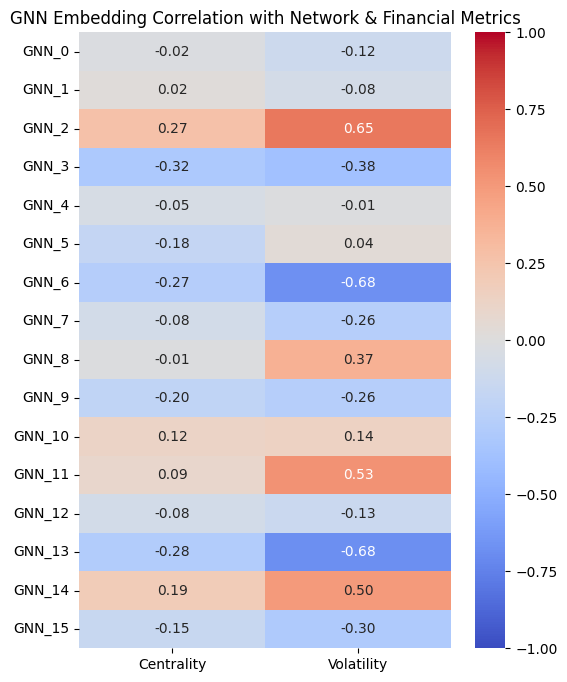

In [7]:
# --- Run Correlation Analysis ---
# What financial concepts did the GNN learn?

# Calculate the correlation matrix
corr_matrix = analysis_df.corr(numeric_only=True)

# We only care about the correlation between GNN features and our financial metrics
gnn_corr = corr_matrix[['Centrality', 'Volatility']].drop(['Centrality', 'Volatility'])

print("Correlation of GNN Embeddings vs. Financial/Graph Metrics:")
print(gnn_corr)

# --- Plot the heatmap ---
plt.figure(figsize=(6, 8))
sns.heatmap(gnn_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
plt.title("GNN Embedding Correlation with Network & Financial Metrics")
plt.show()

Starting quantitative interpretability analysis...
Calculated Network Centrality.
Calculated Financial Metrics.
Merged all features.

--- Correlation Matrix (GNN Dims vs. Features) ---
        DegreeCentrality  BetweennessCentrality  EigenvectorCentrality  \
GNN_0          -0.019170              -0.064935              -0.088905   
GNN_1           0.021282              -0.025454               0.031214   
GNN_2           0.271540               0.217768               0.454991   
GNN_3          -0.318519              -0.251154              -0.572587   
GNN_4          -0.051250              -0.023658              -0.083572   
GNN_5          -0.178190              -0.138940              -0.347506   
GNN_6          -0.272572              -0.233791              -0.439658   
GNN_7          -0.084106              -0.074166              -0.118891   
GNN_8          -0.010260              -0.017329              -0.053687   
GNN_9          -0.201917              -0.186630              -0.363708   
G

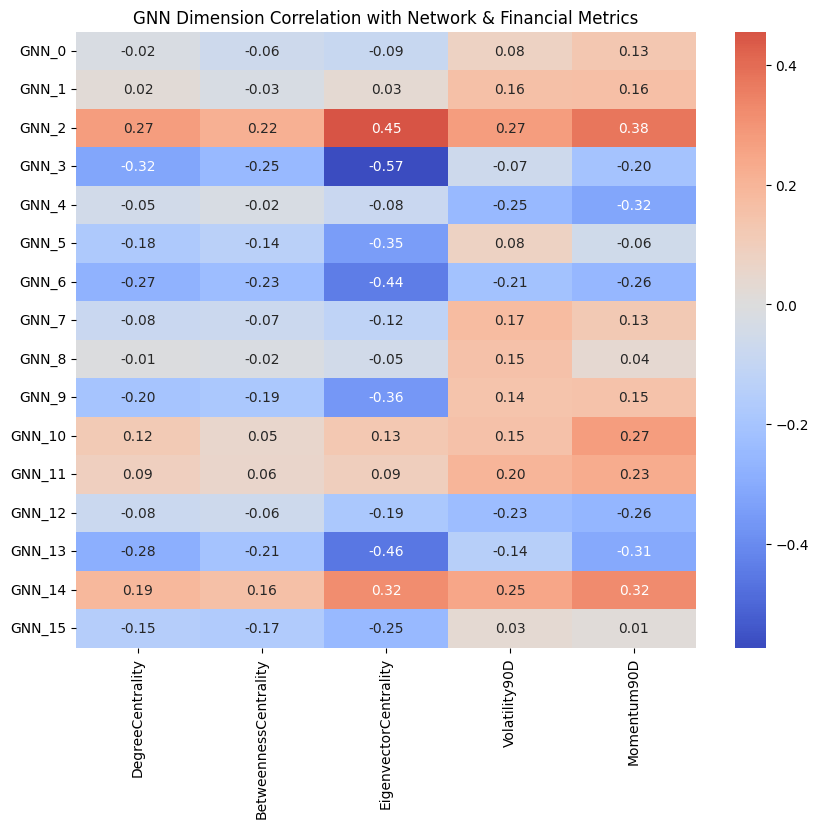

In [10]:
# --- This is the new, corrected analysis cell ---
# It uses your variable names: 'G' and 'price_df'

print("Starting quantitative interpretability analysis...")

try:
    # --- 1. Calculate Network Centrality Metrics ---
    # Using 'G' (your variable) instead of 'G_tmfg'
    degree_centrality = nx.degree_centrality(G) 
    betweenness_centrality = nx.betweenness_centrality(G)
    eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=500)

    # Convert to DataFrame
    centrality_df = pd.DataFrame({
        'Stock': list(G.nodes()),
        'DegreeCentrality': pd.Series(degree_centrality),
        'BetweennessCentrality': pd.Series(betweenness_centrality),
        'EigenvectorCentrality': pd.Series(eigenvector_centrality)
    }).set_index('Stock')

    print("Calculated Network Centrality.")

    # --- 2. Calculate Financial Metrics ---
    # Using 'price_df' (your variable) instead of 'price_data'
    returns = price_df.pct_change()
    
    # Get last valid data point (as of end of training period)
    volatility_90d = returns.rolling(90).std().iloc[-1]
    volatility_90d.name = 'Volatility90D'
    
    momentum_90d = price_df.pct_change(90).iloc[-1]
    momentum_90d.name = 'Momentum90D'
    
    financial_metrics_df = pd.concat([volatility_90d, momentum_90d], axis=1)
    
    print("Calculated Financial Metrics.")

    # --- 3. Merge all features into analysis_df ---
    # 'analysis_df' should already exist from your t-SNE cell
    # We create 'analysis_df_full' to hold these new merged features
    analysis_df_full = analysis_df.merge(centrality_df, left_index=True, right_index=True)
    analysis_df_full = analysis_df_full.merge(financial_metrics_df, left_index=True, right_index=True)

    print("Merged all features.")

    # --- 4. Run the final Correlation Analysis ---
    gnn_cols = [col for col in analysis_df_full.columns if col.startswith('GNN_')]
    feature_cols = ['DegreeCentrality', 'BetweennessCentrality', 'EigenvectorCentrality', 'Volatility90D', 'Momentum90D']
    
    # Handle potential NaNs from rolling metrics or missing data
    analysis_df_full[feature_cols] = analysis_df_full[feature_cols].fillna(0)
    
    correlation_matrix = analysis_df_full[gnn_cols + feature_cols].corr()
    correlation_subset = correlation_matrix.loc[gnn_cols, feature_cols]

    # --- 5. Display the results ---
    print("\n--- Correlation Matrix (GNN Dims vs. Features) ---")
    print(correlation_subset)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        correlation_subset, 
        annot=True, 
        cmap='coolwarm', 
        center=0, 
        fmt='.2f'
    )
    plt.title("GNN Dimension Correlation with Network & Financial Metrics")
    plt.savefig("gnn_correlation_heatmap.png", bbox_inches='tight')
    plt.show()

except NameError as e:
    print(f"\n--- ERROR: A variable was not defined ---")
    print(f"Details: {e}")
    print("This can happen if you haven't run your Cell 2 (data loading) and t-SNE cell yet.")
except Exception as e:
    print(f"\nAn unexpected error occurred: {e}")

In [11]:
# --- 1. Load REAL Data ---
#
# We are now loading the CSV file generated by walk_forward.py
#
returns_file = "walk_forward_returns.csv" # This is the file your script just created

if not os.path.exists(returns_file):
    print(f"--- ERROR: '{returns_file}' not found! ---")
    raise FileNotFoundError(f"'{returns_file}' not found. Cannot run p-value test.")

real_returns_series = pd.read_csv(
    returns_file,
    index_col=0,       # The first column (Date) is the index
    parse_dates=True   # Treat the index as dates
).squeeze()            # .squeeze() turns the 1-col DataFrame into a Series

print(f"Successfully loaded '{returns_file}'.")
print(f"Loaded 'real' returns. N-days: {len(real_returns_series)}")

Successfully loaded 'walk_forward_returns.csv'.
Loaded 'real' returns. N-days: 2959


Loaded real returns (2959 days) and signals ((2959, 48))
Testing cost levels: [0.0005, 0.001, 0.0025, 0.005, 0.01]

Estimated Annual Turnover: 1276.62%

--- Cost Sensitivity Results (CAGR) ---
  Cost 0.05%: 16.86% CAGR
  Cost 0.10%: 16.22% CAGR
  Cost 0.25%: 14.31% CAGR
  Cost 0.50%: 11.12% CAGR
  Cost 1.00%: 4.73% CAGR


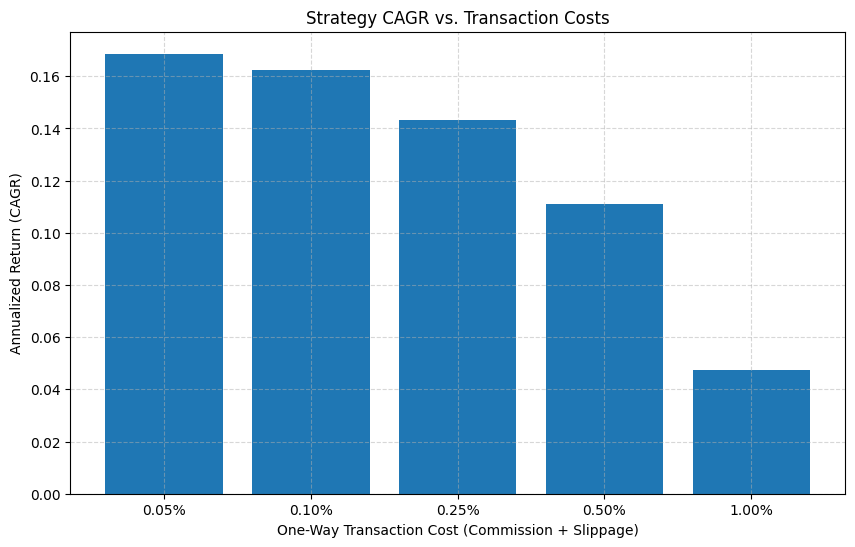

In [12]:
# --- 1. Load REAL Data (Returns & Signals) ---

# Load REAL returns
returns_file = "walk_forward_returns.csv"
real_returns_series = pd.read_csv(
    returns_file, index_col=0, parse_dates=True
).squeeze()

# Load REAL signals
signals_file = "walk_forward_signals.csv"
if not os.path.exists(signals_file):
    print(f"--- ERROR: '{signals_file}' not found! ---")
    raise FileNotFoundError(f"'{signals_file}' not found. Cannot run turnover test.")

real_signals_df = pd.read_csv(
    signals_file, index_col=0, parse_dates=True
)

print(f"Loaded real returns ({len(real_returns_series)} days) and signals ({real_signals_df.shape})")

# --- 2. Define Turnover Function ---
def calculate_annual_turnover(signals_df):
    """
    Calculates the average *annual* turnover.
    A turnover of 1.0 means 100% of the portfolio was traded over the year.
    """
    # .diff() shows the change in position (i.e., the trade)
    # .abs() counts both buys (0 to 1) and sells (1 to 0)
    # .sum(axis=1) sums all trades across all stocks for that day
    daily_trades = signals_df.diff().abs().sum(axis=1)
    
    # Get the number of active positions (1s or -1s)
    # We use .shift(1) to avoid counting the position we *just* entered
    active_positions = signals_df.shift(1).abs().sum(axis=1)
    
    # Daily turnover %
    daily_turnover = daily_trades / active_positions.replace(0, 1) # Avoid divide by zero
    
    # Average daily turnover * 252 trading days
    annual_turnover = daily_turnover.mean() * 252
    return annual_turnover
    
# --- 3. Define Cost Sensitivity Function ---
def run_cost_sensitivity_analysis(returns_series, signals_df, cost_levels):
    """
    Calculates the final CAGR for a range of transaction costs.
    """
    annual_turnover = calculate_annual_turnover(signals_df)
    
    # Calculate baseline CAGR
    base_cagr = (1 + returns_series.mean() * 252) - 1
    
    results = {}
    
    for cost in cost_levels:
        # Total annual cost drag = Annual Turnover * Cost per Trade
        cost_drag = annual_turnover * cost
        
        # Subtract the cost drag from the return
        adjusted_cagr = base_cagr - cost_drag
        
        results[f"{cost*100:.2f}%"] = adjusted_cagr
        
    return results, annual_turnover

# --- 4. Run the Analysis ---
cost_levels_to_test = [0.0005, 0.001, 0.0025, 0.005, 0.01] # 0.05% to 1.0%
print(f"Testing cost levels: {cost_levels_to_test}")

cost_results, turnover = run_cost_sensitivity_analysis(
    real_returns_series, 
    real_signals_df,
    cost_levels_to_test
)

print(f"\nEstimated Annual Turnover: {turnover * 100:.2f}%")
print("\n--- Cost Sensitivity Results (CAGR) ---")
for cost_pct, cagr in cost_results.items():
    print(f"  Cost {cost_pct}: {cagr*100:.2f}% CAGR")

# Plot the results
plt.figure(figsize=(10, 6))
plt.bar(cost_results.keys(), cost_results.values())
plt.title("Strategy CAGR vs. Transaction Costs")
plt.xlabel("One-Way Transaction Cost (Commission + Slippage)")
plt.ylabel("Annualized Return (CAGR)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig("cost_sensitivity_analysis.png", bbox_inches='tight')
plt.show()

In [13]:
# --- This is a new cell for analysis.ipynb ---
#
# Part 3: Analyzing the "Alphas"
#
# This loads and prints the 12 champion GNN-based strategies
# discovered by the walk-forward process.

print("--- Champion Strategies (GNN) ---")
try:
    gnn_champions_df = pd.read_csv("walk_forward_champions.csv")
    
    for index, row in gnn_champions_df.iterrows():
        print(f"  Year {row['year']}: {row['strategy']}")

except FileNotFoundError:
    print("Could not find 'walk_forward_champions.csv'")

--- Champion Strategies (GNN) ---
  Year 2013: sma_20_op(add(GNN_0, GNN_4))
  Year 2014: NOT(lt(sma_5(sma_20), sma_20))
  Year 2015: add(add(AND(GNN_13, GNN_0), sub(GNN_8, GNN_13)), pdiv(log_abs(GNN_10), min(GNN_0, GNN_7)))
  Year 2016: abs(gt(GNN_6, GNN_10))
  Year 2017: sub(mul(mul(GNN_8, GNN_9), GNN_15), GNN_1)
  Year 2018: sma_20_op(pdiv(gt(GNN_9, lt(gt(GNN_14, GNN_10), mul(GNN_15, GNN_4))), sub(log_abs(min(GNN_12, GNN_0)), GNN_6)))
  Year 2019: gt(sma_20_op(atr_14), atr_14)
  Year 2020: lt(GNN_0, min(sub(GNN_12, GNN_5), min(sma_20, GNN_13)))
  Year 2021: sma_20_op(min(GNN_14, GNN_4))
  Year 2022: mul(sub(AND(min(GNN_2, GNN_2), OR(GNN_9, GNN_6)), lt(min(GNN_1, GNN_0), GNN_11)), pdiv(pdiv(GNN_11, GNN_6), add(min(atr_14, atr_14), max(gt(GNN_7, GNN_15), GNN_7))))
  Year 2023: sub(GNN_10, log_abs(log_abs(atr_14)))
  Year 2024: sma_5(NOT(gt(GNN_6, pdiv(GNN_5, GNN_10))))


--- Plotting Final GNN vs. Baseline Comparison ---
Successfully loaded both GNN and NO_GNN returns files.


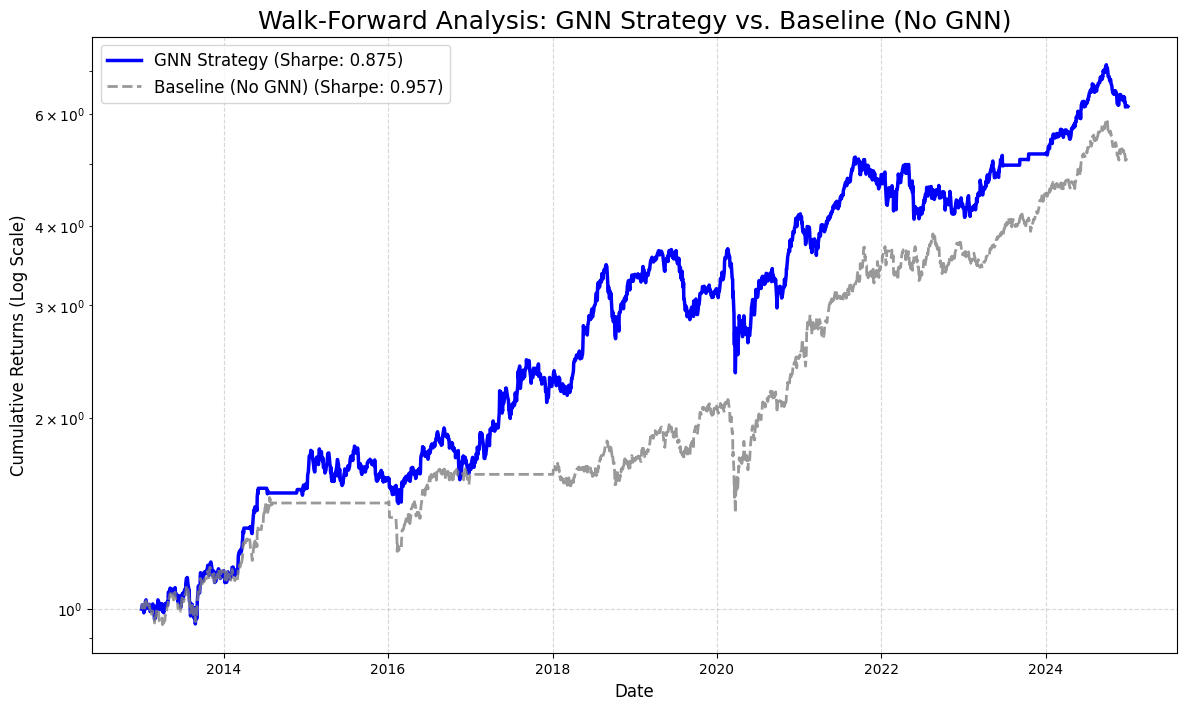

In [14]:
# --- This is the FINAL cell for analysis.ipynb ---
#
# Part 4: The "Money Chart" - GNN vs. Baseline
#
# This chart is the final, most important proof for the entire project.

print("--- Plotting Final GNN vs. Baseline Comparison ---")

try:
    # Load GNN returns
    gnn_returns = pd.read_csv(
        "walk_forward_returns.csv", index_col=0, parse_dates=True
    ).squeeze()
    gnn_returns.name = "GNN Strategy"
    gnn_equity = (1 + gnn_returns.fillna(0)).cumprod()
    
    # Load NO-GNN (Baseline) returns
    no_gnn_returns_file = "walk_forward_returns_NO_GNN.csv"
    no_gnn_returns = pd.read_csv(
        no_gnn_returns_file, index_col=0, parse_dates=True
    ).squeeze()
    no_gnn_returns.name = "Baseline (No GNN)"
    no_gnn_equity = (1 + no_gnn_returns.fillna(0)).cumprod()

    print("Successfully loaded both GNN and NO_GNN returns files.")

    # --- Plot the Comparison ---
    plt.figure(figsize=(14, 8))
    
    # Get final metrics for labels
    gnn_sharpe = (gnn_returns.mean() / gnn_returns.std()) * np.sqrt(252)
    no_gnn_sharpe = (no_gnn_returns.mean() / no_gnn_returns.std()) * np.sqrt(252)
    
    plt.plot(
        gnn_equity.index, 
        gnn_equity, 
        color='blue', 
        linewidth=2.5, 
        label=f"GNN Strategy (Sharpe: {gnn_sharpe:.3f})"
    )
    plt.plot(
        no_gnn_equity.index, 
        no_gnn_equity, 
        color='gray', 
        linestyle='--', 
        linewidth=2, 
        alpha=0.8,
        label=f"Baseline (No GNN) (Sharpe: {no_gnn_sharpe:.3f})"
    )
    
    plt.title("Walk-Forward Analysis: GNN Strategy vs. Baseline (No GNN)", fontsize=18)
    plt.ylabel("Cumulative Returns (Log Scale)", fontsize=12)
    plt.xlabel("Date", fontsize=12)
    plt.yscale('log')
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.savefig("final_comparison_equity_curve.png", bbox_inches='tight')
    plt.show()

except FileNotFoundError:
    print(f"\n--- ERROR: 'walk_forward_returns_NO_GNN.csv' not found! ---")
    print("This is expected.")
    print("Please run 'python E:\\QuantProject\\walk_forward_NO_GNN.py' and then re-run this cell.")
except Exception as e:
    print(f"An error occurred: {e}")